## Preprocessing

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score # One metric for finding the optimal number of clusters
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import json
import time
import random

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Let's define the hyperparameters and complete the necessary preprocessing steps.

In [2]:
TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1
TIME_WINDOW_SIZE = 12
EPOCHS = 5

NUMBER_OF_CLIENTS = 10 # Controls the number of households used for forecasting.
WARMUP_ROUNDS = 5 # Controls the number of warmup rounds before clustered federated learning starts.
CFL_ROUNDS = 5 # Rounds under clustered FL.
N_CLUSTERS = 2 # Number of clusters assumed to be available in the dataset.

In [7]:
def load_data():
    df = pd.read_csv('combined.csv', parse_dates=[1])
    return df

def basic_preprocess_fn(df:pd.DataFrame):
    """ Selects the electricity data with standard tariffs belonging to year 2013 and sorts the dataframe based on 
    DateTime column. """
    
    temp = df[df['DateTime'].dt.strftime('%Y') == '2013'].sort_values(by=['DateTime'])
    #temp = temp[temp['stdorToU'] == 'Std']
    #temp = temp.drop(axis=1, columns = 'stdorToU')
    return temp

def extract_clients(df:pd.DataFrame):
    """ Extracts client ids and client data from the given dataframe, which is assumed to hold multiple 
    client information."""
    
    client_keys = df['LCLid'].value_counts().keys().tolist()
    client_list = []

    for key in client_keys:
        client_df = df[df['LCLid'] == key]
        client_list.append(client_df)

    return client_keys, client_list

def resample_fn(df:pd.DataFrame):
    """ Resamples the time-series dataframe so that it reflects hourly electricity consumption values. It also does
    basic data processing such as dropping unnecessary columns. """
    
    resample_df = df.astype({"KWH/hh (per half hour) ": float}).drop(columns = ['LCLid']).set_index('DateTime').resample(rule='H').sum()
    resample_df.rename(columns = {'KWH/hh (per half hour) ':'kWh'}, inplace = True)
    return resample_df

def remove_bad_clients(client_keys:list, client_list:list):
    """ Drops the clients with datapoints fewer than 0.9 percent of the client with highest amount of data. """
    
    sizes = [len(e) for e in client_list]
    biggest_client = max(sizes) 
    ratios = [size/biggest_client for size in sizes]
    indices_to_keep = [idx for idx,e in enumerate(ratios) if e>=0.9]
    
    client_keys_selected = [client_keys[index] for index in indices_to_keep]
    client_list_selected = [client_list[index] for index in indices_to_keep]
    
    return client_keys_selected, client_list_selected

def create_client_dict(client_keys, client_data_list):
    """ Matches every client ID with its own electricty consumption data and returns the pairs in a python dictionary. """
    client_dict = {}
    for key, df in zip(client_keys, client_data_list):
        client_dict[key] = df
        
    return client_dict

In [8]:
df = load_data()
temp = basic_preprocess_fn(df)
client_keys, client_list = extract_clients(temp)
client_list_resampled = list(map(resample_fn, client_list))
client_keys_selected, client_list_selected = remove_bad_clients(client_keys, client_list_resampled)
client_dict = create_client_dict(client_keys_selected, client_list_selected)

## Creating the Client Class

We will now define the client class and its attributes. Explaining the attributes of the Client and Server classes will make this notebook very lengthy in size, so it's better to check the original FL+HC paper if you'd like to understand its workflow.

In [9]:
class Client:
    def __init__(self, cid, data, round_id = None, cluster_id = None):
    
        self.cid = cid
        self.df = data
        self.round_id = round_id
        self.val_loss_hist = []
        #self.weights_hist = []
        self.cluster_id = cluster_id
        
    def create_model(self): 
        """ Initialize an LSTM model."""
        self.model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, dropout=0.1, return_sequences=True),
        tf.keras.layers.LSTM(16, dropout=0.1),
        tf.keras.layers.Dense(1),
        ])
        return self.model
    
    def train_test_val_split(self):
        """ Splits the client data into train, test and validation datasets. """

        df_size = self.df.shape[0]

        self.train = self.df.iloc[:int(df_size * 0.7)]
        self.val = self.df.iloc[int(df_size * 0.7):int(df_size * 0.9)]
        self.test = self.df.iloc[int(df_size * 0.9):]

        return self.train, self.val, self.test
    
    def normalize_fn(self, scaler = MinMaxScaler()):
        """ Normalizes the input arrays with the given scaler. Train array is taken as the reference. """

        self.train_sc = scaler.fit_transform( self.train.values )
        self.val_sc = scaler.transform( self.val.values )
        self.test_sc = scaler.transform( self.test.values )
        self.scaler = scaler
        
        return self.train_sc, self.val_sc, self.test_sc, self.scaler
    
    def create_tensor_datasets(self):
        """ Applies the window function on the scaled train,test and validation arrays. Output will be tf.data datasets."""
        
        def window_fn(input_array, window_size=TIME_WINDOW_SIZE, batch_size=TRAIN_BATCH_SIZE):
            """ Creates time series windows for the given input array and returns them as a batch of tensorflow dataset."""
            dataset = tf.data.Dataset.from_tensor_slices(input_array)
            dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
            dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
            dataset = dataset.map(lambda window: (window[:-1], window[-1:]), num_parallel_calls=10)
            dataset = dataset.batch(batch_size, num_parallel_calls=10).prefetch(1)

            return dataset
    
        self.train_tf = window_fn(self.train_sc, window_size = TIME_WINDOW_SIZE)
        self.val_tf = window_fn(self.val_sc, window_size = TIME_WINDOW_SIZE)
        self.test_tf = window_fn(self.test_sc, window_size = TIME_WINDOW_SIZE, batch_size=TEST_BATCH_SIZE)
        
        return self.train_tf, self.val_tf, self.test_tf
        
    def train_fn(self, lr = 0.002, opt = tf.keras.optimizers.Adam, epochs = EPOCHS):
        """ Fits the model on train&validation data and returns the corresponding MSE loss values. """
        model = self.model
        train = self.train_tf
        validation = self.val_tf
        
        learning_rate = lr
        optimizer = opt(learning_rate = lr)
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=["mse"])
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        history = model.fit(x=train, epochs=epochs, validation_data=validation, callbacks=[callback], verbose=False)
        # self.train_loss = history.history['loss']
        self.val_loss = history.history['val_loss']
        self.val_loss_hist.append(self.val_loss)
        return # self.train_loss, self.val_loss
    
    def evaluate(self):
        """ Evaluate the trained local model on local test set, return predicstions and test MSE."""
        new_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, dropout=0.1, batch_input_shape = (1,12,1), return_sequences=True),
        tf.keras.layers.LSTM(16, dropout=0.1),
        tf.keras.layers.Dense(1),
        ])
        new_model.set_weights(self.model.get_weights())
        
        forecast = self.model.predict(self.test_tf)
        self.predictions = self.scaler.inverse_transform(forecast)
        self.pred_df = pd.DataFrame(data = self.predictions, columns = list(self.df.columns.values))
        self.test_metrics = round(mean_squared_error(self.test[TIME_WINDOW_SIZE:], self.predictions), 5)
        self.r2 = round(r2_score(self.test[TIME_WINDOW_SIZE:], self.predictions), 5)
        self.test_metrics_pct = round(mean_absolute_percentage_error(self.test[TIME_WINDOW_SIZE:], self.predictions), 5)

        return # self.predictions, self.test_metrics
    
    def set_weights(self, avg_weights):
        """ Set the model weights taken from the server."""
        return self.model.set_weights(avg_weights)
    
    def send_weights(self):
        """ Send the local model's weights to server. """
        weights = np.array(self.model.get_weights(), dtype=object)
        #self.weights_hist.append(weights)
        return weights

## Creating the Server Class

Similar to the Client class, Server class too is a complex one. Check the original FL+HC paper, or the thesis itself if you want to understand how the coordination process happens.

We also need to add the instantiation function that gets a client dictionary and transforms all of its elements into a client object, which are then stored in a list.

In [10]:
def instantiate_clients(client_dict):
    """ Takes a dictionary of client, client_data pairs and returns a list of client objects. """
    
    client_objects = []
    for client, data in client_dict.items():
        instance = Client(cid = client, data = data.iloc[:4380]) # Changed to a subset of data for fast experimentation.
        client_objects.append(instance)
    return client_objects

class Server:
  def __init__(self, number_of_warmup_rounds, rounds_after_clustering):
    self.warmup_rounds = number_of_warmup_rounds
    self.clustering_rounds = rounds_after_clustering
    self.current_rnd = 0
    self.mses_overall = []
    self.r2_overall = []
    self.mapes_overall = []

  def initialize_clients(self, client_instances):
    """ Takes a list of client instances and configures their data and model
    for training."""

    for cl in client_instances:
      cl.create_model()
      cl.train_test_val_split()
      cl.normalize_fn()
      cl.create_tensor_datasets()
    return

  def average_weights(self, ser):
    """ Takes a list of client weights and averages them. """
    weights_avg = np.mean( np.array(ser), axis = 0)
    return weights_avg

  def train_and_evaluate(self, client_instances):
    """ Runs federated training & evaluation for the given number of rounds. """

    for i in tf.range(self.warmup_rounds):
      """ Block that checks the current round and sets the mean weights to all clients before training process."""
      start = time.time()
      if self.current_rnd != 0:
          avg = self.average_weights(self.weights_list)
          for cl in client_instances:
              cl.set_weights(avg)
        
      """ Block for training the model on clients, getting their weights and appending them to the server's 
      weight list to be used with FedAVG algorithm. """
      self.weights_list = []
      round_test_mses = []
      round_test_mapes = []
      round_test_r2s = []
      for cl in client_instances:
          cl.train_fn()
          cl.evaluate()
          
          if cl.round_id == None:
              cl.round_id = 1
          else:
              cl.round_id += 1
              
          cl_w = cl.send_weights()
          self.weights_list.append(cl_w)
          round_test_mses.append(cl.test_metrics)
          round_test_r2s.append(cl.r2)
          round_test_mapes.append(cl.test_metrics_pct)

      mean_mse = round(np.mean(round_test_mses), 4)
      mean_mape = round(np.mean(round_test_mapes), 4)
      mean_r2 = round(np.mean(round_test_r2s), 4)
      self.mses_overall.append(mean_mse)
      self.mapes_overall.append(mean_mape)
      self.r2_overall.append(mean_r2)

      self.current_rnd += 1
      end = time.time()
      print("Time Spent for the Round {}:".format(self.current_rnd), round((end-start)/60, 2), 'minutes')
    return

  def train_and_evaluate_with_clusters(self, client_instances):
    """ Given the warmup FL phase is completed, this method clusters the clients
    based on their validation/train loss taken from their latest epoch. It then
    applies normal FedAvg -separately- on those clusters. """

    def create_loss_df():
      """ Creates a dataframe holding client id, loss and client weight values.
      This complements the client_instances data structure. """

      losses_of_last_round = {}

      for cl in client_instances:
        cid = cl.cid
        latest_loss = cl.val_loss[-1]
        losses_of_last_round[cid] = latest_loss

      loss_df = pd.DataFrame.from_dict(losses_of_last_round, orient='index')
      loss_df = loss_df.reset_index()
      loss_df.columns = ['Cid', 'Loss']
      loss_df['Weights'] = self.weights_list
      return loss_df

    def apply_clustering(loss_df, cluster_fn):
      """ Applies the given clustering function on the client loss values present
      in the loss_df dataframe, and returns the cluster labels of the clients. """

      cluster_instance = cluster_fn
      cluster_instance.fit_predict(loss_df['Loss'].values.reshape(-1,1))
      cluster_labels = cluster_instance.labels_
      #loss_df['Cluster'] = cluster_labels
      return cluster_labels
    
    """ Initialization of the clusters & weights before the training begins. """
    loss_df = create_loss_df()
    loss_df['Cluster'] = apply_clustering(loss_df, AgglomerativeClustering(n_clusters=N_CLUSTERS, linkage='ward'))
    loss_df = loss_df.join(loss_df.groupby(['Cluster']).Weights.apply(self.average_weights), on='Cluster', rsuffix='_Mean')

    for cl in client_instances:
      key = cl.cid
      new_cluster_id = loss_df[loss_df['Cid'] == key].Cluster
      new_weights = loss_df[loss_df['Cid'] == key].Weights_Mean.values[0]
      cl.set_weights(new_weights)
      cl.cluster_id = new_cluster_id

    """ Training block for Clustered Federated Learning. It is a bit more complex
    than that of train_and_evaluate method but not much different. The two data
    structures, loss_df and client_instances work together here. """

    for i in tf.range(self.clustering_rounds):

      start = time.time()
      if i != 0:
        loss_df.drop('Weights_Mean', axis = 1, inplace=True)
        loss_df = loss_df.join(loss_df.groupby(['Cluster']).Weights.apply(self.average_weights), on='Cluster', rsuffix='_Mean')
        #loss_df.loc[:, 'Weights_Mean'] = loss_df.groupby(['Cluster']).Weights.apply(self.average_weights)
        #print(loss_df)
        for cl in client_instances:
          key = cl.cid
          new_weights = loss_df[loss_df['Cid'] == key].Weights_Mean.values[0]
          cl.set_weights(new_weights)

      round_test_mses = []
      round_test_mapes = []
      round_test_r2s = []
      for cl in client_instances:
        key = cl.cid
        cl.train_fn()
        cl.evaluate()

        if cl.round_id == None:
          cl.round_id = 1
        else:
          cl.round_id += 1

        cl_w = cl.send_weights()

        #loss_df[loss_df['Cid'] == key]['Weights'] = np.array([cl_w])
        loss_df.loc[loss_df.Cid == key,'Weights'] = pd.Series([cl_w], dtype=object).values
        round_test_mses.append(cl.test_metrics)
        round_test_r2s.append(cl.r2)
        round_test_mapes.append(cl.test_metrics_pct)

      mean_mse = round(np.mean(round_test_mses), 4)
      mean_r2 = round(np.mean(round_test_r2s), 4)
      mean_mape = round(np.mean(round_test_mapes), 4)
      self.mses_overall.append(mean_mse)
      self.mapes_overall.append(mean_mape)
      self.r2_overall.append(mean_r2)  
      self.current_rnd += 1
      end = time.time()
      print("Time Spent for the CFL Round {}:".format(i), round((end-start)/60, 2), 'minutes')

    return

## Experiments

### Main

In [11]:
client_objects = instantiate_clients(client_dict)
random.seed(10)
client_objects_short = random.sample(client_objects, NUMBER_OF_CLIENTS)

In [12]:
server = Server(number_of_warmup_rounds = WARMUP_ROUNDS, rounds_after_clustering = CFL_ROUNDS)

In [13]:
server.initialize_clients(client_objects_short)

In [14]:
server.train_and_evaluate(client_objects_short)

Time Spent for the Round 1: 1.66 minutes
Time Spent for the Round 2: 1.33 minutes
Time Spent for the Round 3: 1.36 minutes
Time Spent for the Round 4: 1.33 minutes
Time Spent for the Round 5: 1.34 minutes


In [15]:
server.train_and_evaluate_with_clusters(client_objects_short)

Time Spent for the CFL Round 0: 1.37 minutes
Time Spent for the CFL Round 1: 1.37 minutes
Time Spent for the CFL Round 2: 1.45 minutes
Time Spent for the CFL Round 3: 1.35 minutes
Time Spent for the CFL Round 4: 1.41 minutes


## Clients' Test MSE Scores

Let's first take a look at the metrics and then plot the forecasting results.

Average test MSE over all clients: 0.1685
Average test R2 over all clients: -1.3112


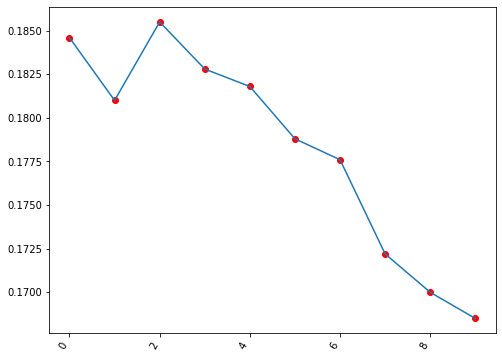

In [16]:
print('Average test MSE over all clients:', server.mses_overall[-1])
print('Average test R2 over all clients:', server.r2_overall[-1])
rounds = [int(i) for i in range(WARMUP_ROUNDS+CFL_ROUNDS)]

plt.plot(rounds, server.mses_overall)
plt.scatter(x=rounds, y=server.mses_overall, color='r')
plt.xticks(rotation=60, ha='right')
plt.savefig('MSE Curve.png')
plt.show()
plt.close()


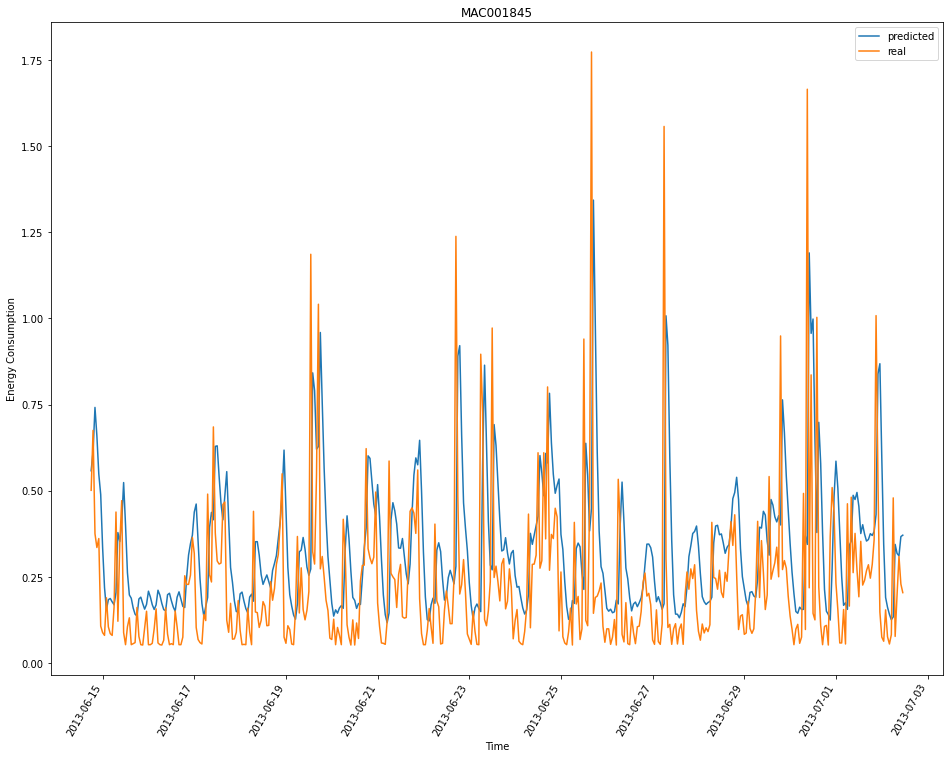

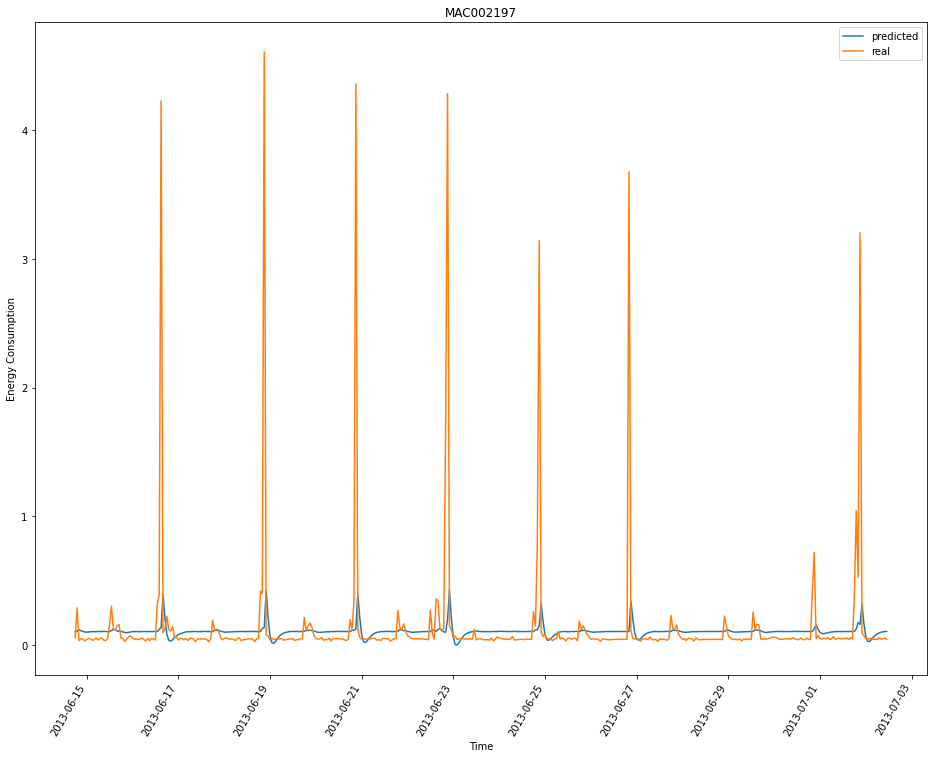

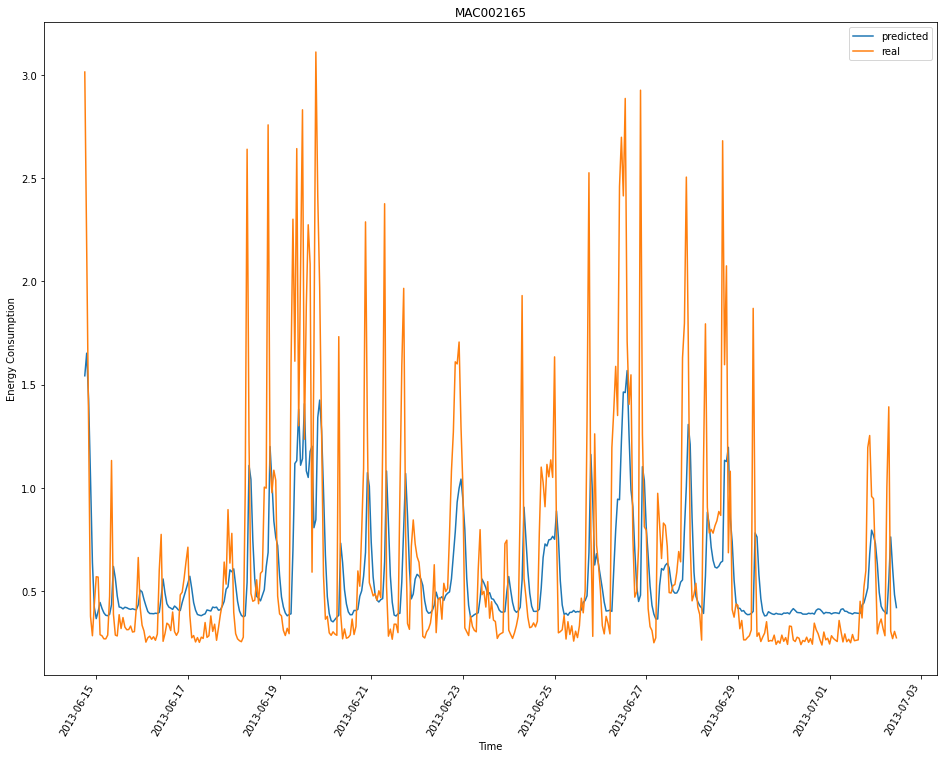

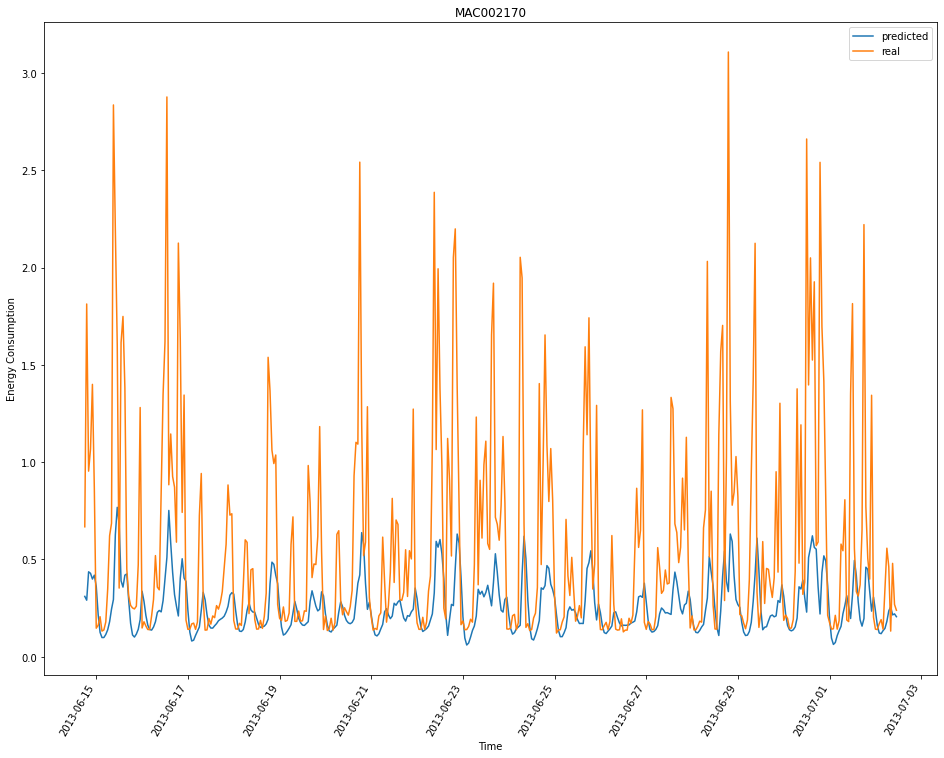

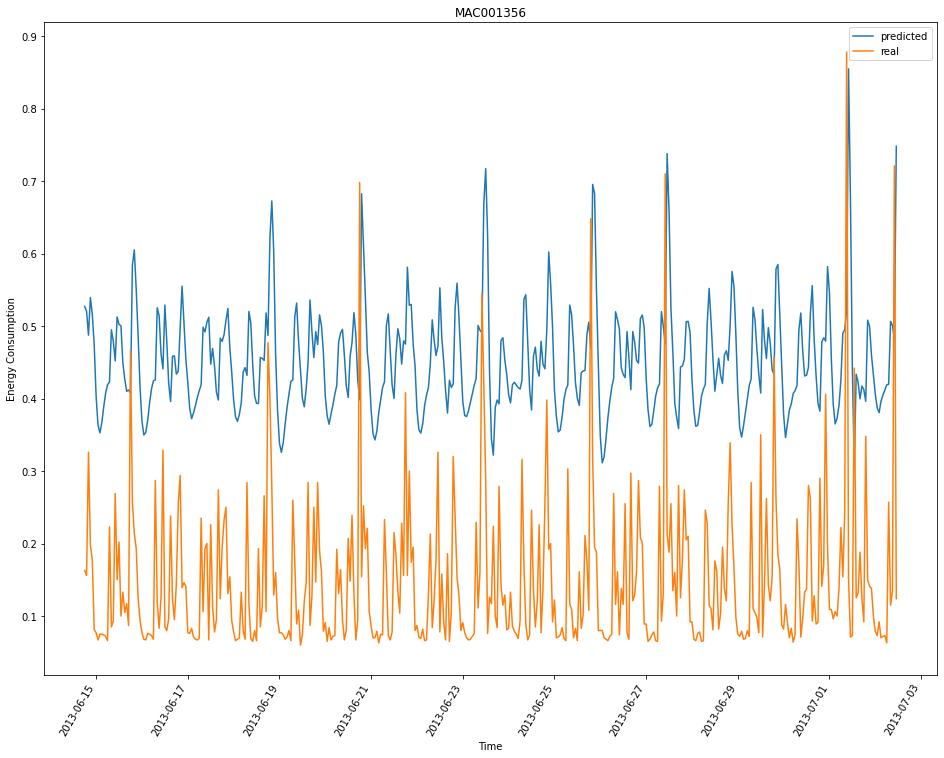

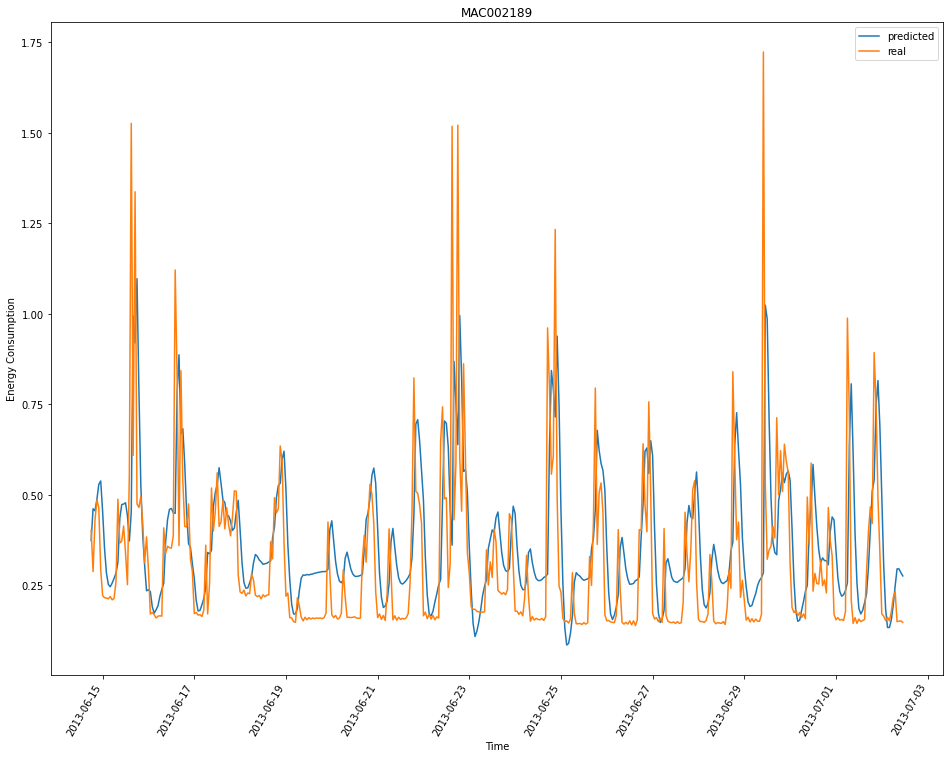

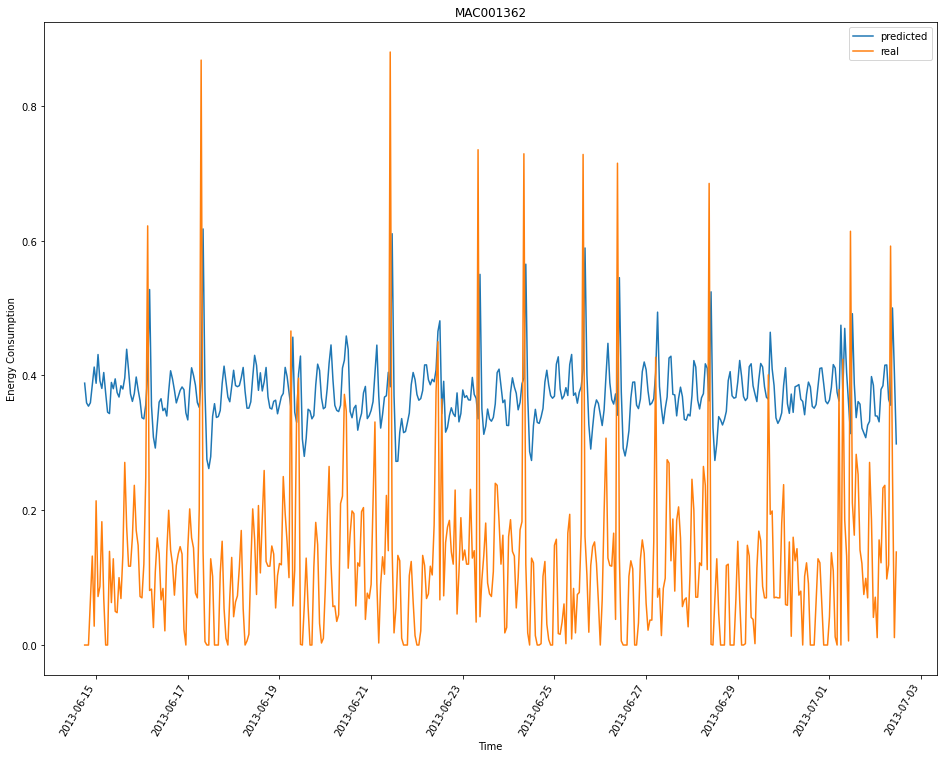

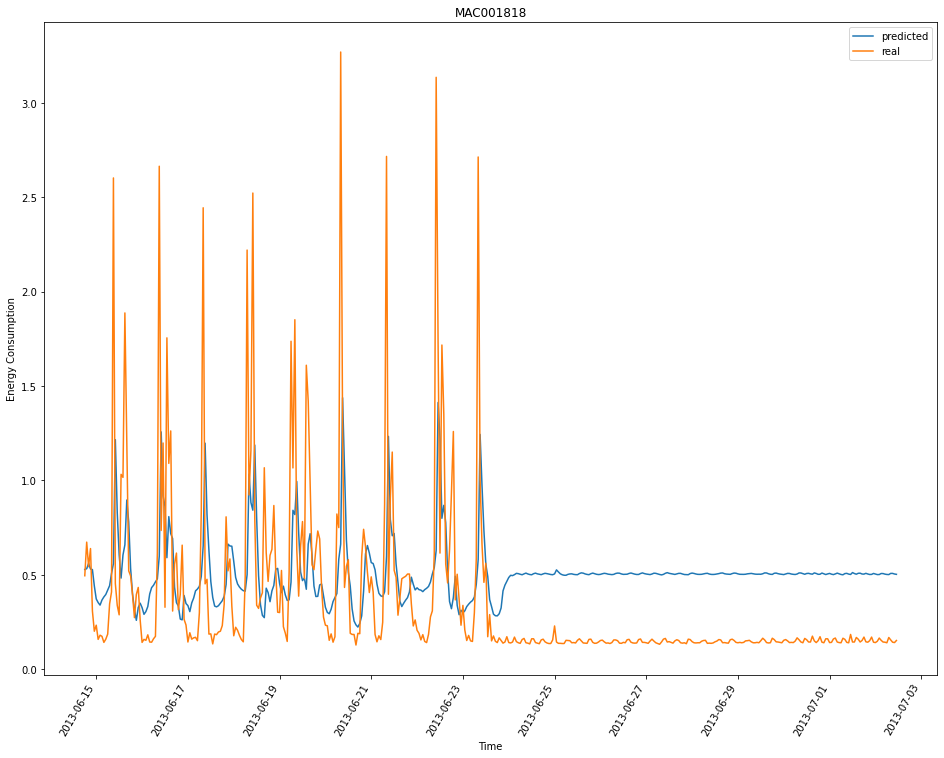

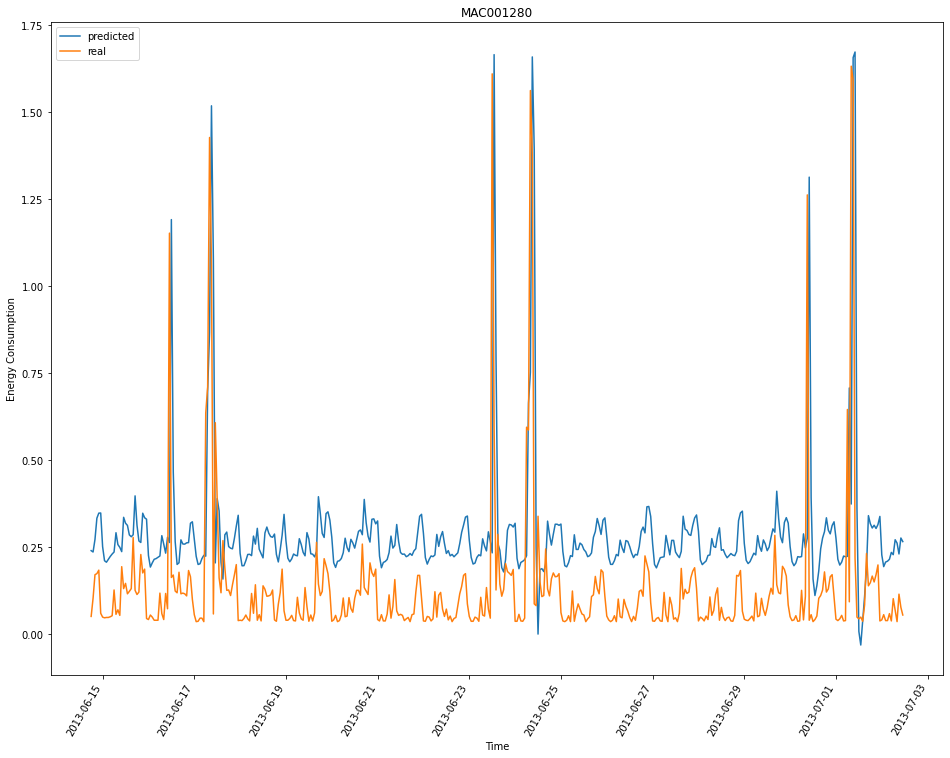

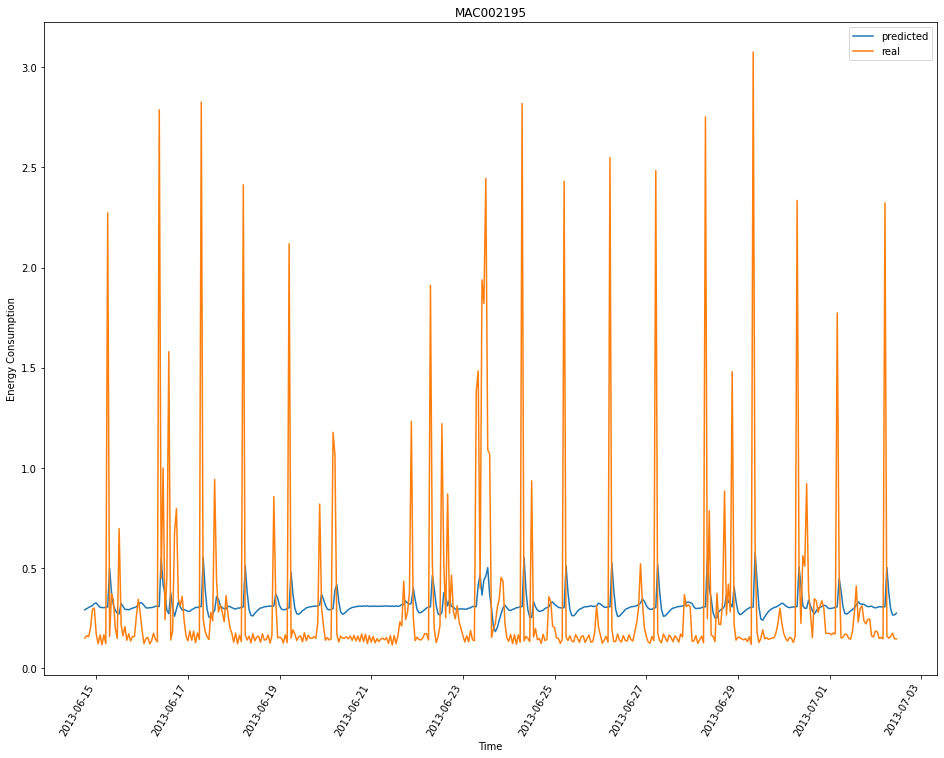

In [17]:
for cl in client_objects_short:
  pred = cl.pred_df.values
  true = cl.test.iloc[TIME_WINDOW_SIZE:, :].values

  x_ax = list(cl.test.iloc[TIME_WINDOW_SIZE:, :].index)
  mpl.rcParams['figure.figsize'] = (16, 12)

  plt.plot(x_ax, pred, label='predicted')
  plt.plot(x_ax, true, label='real')
  plt.xticks(rotation=60, ha='right')
  plt.title(cl.cid)
  plt.ylabel("Energy Consumption")
  plt.xlabel("Time")
  plt.legend()
  plt.show()

## Visualizing Clusters

This is mainly for aesthetics and understanding. I was curious about the clusters, and if the selected value for number of clusters seem to be correct, so I decided to visualize them. There are several ways to find the optimal value for setting the correct number of clusters but optimizing that hyperparamater is more of a later task.

In [31]:
cluster_labels = []
loss_values = []
client_ids = []
for cl in client_objects_short:
  client_ids.append(cl.cid)
  loss_values.append(cl.val_loss_hist[WARMUP_ROUNDS-1][-1]) # Validation Loss of client right after the end of warmup rounds. Clusters were formed wrt to these loss values.
  cluster_labels.append(cl.cluster_id.values[0])

In [32]:
cluster_df = pd.DataFrame()
cluster_df['client'] = client_ids
cluster_df['loss'] = loss_values
cluster_df['cluster'] = cluster_labels

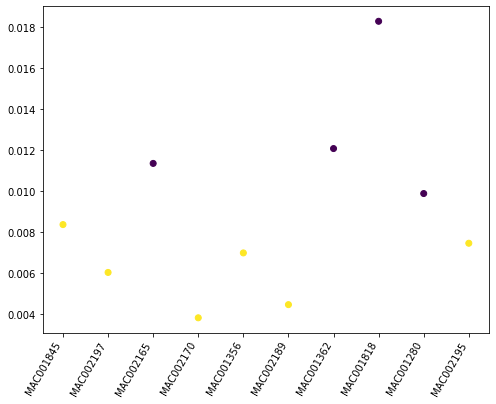

In [33]:
mpl.rcParams['figure.figsize'] = (8, 6)
plt.scatter(x=cluster_df['client'], y=cluster_df['loss'], c=cluster_df['cluster'])
plt.xticks(rotation=60, ha='right')
plt.show()